In [17]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
class CatDogDataset(Dataset):
    def __init__(self, cat_dir, dog_dir, transform=None):
        self.cat_images = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir)]
        self.dog_images = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir)]
        self.all_images = self.cat_images + self.dog_images
        self.labels = [0]*len(self.cat_images) + [1]*len(self.dog_images)
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
      img_path = self.all_images[idx]
      image = Image.open(img_path).convert('RGB')
      label = self.labels[idx]

      if self.transform:
        image = self.transform(image)

      return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
base_path = '/content/drive/MyDrive/Dataset/Cats and Dogs Classification/archive/PetImages'

In [7]:
dataset = CatDogDataset(
    cat_dir=os.path.join(base_path, 'Cat'),
    dog_dir=os.path.join(base_path, 'Dog'),
    transform=transform
)

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                         num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16,
                        num_workers=2, pin_memory=True)

In [9]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()


        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )


        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )


        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )


        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], 1)


In [ ]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )


        self.inception3a = Inception(64, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(832, num_classes)  

    def forward(self, x):


        x = self.conv1(x)


        x = self.inception3a(x)


        x = self.inception3b(x)


        x = self.maxpool(x)


        x = self.inception4a(x)


        x = self.inception4b(x)

        x = self.inception4c(x)


        x = self.inception4d(x)


        x = self.inception4e(x)


        x = self.avgpool(x)


        x = x.view(x.size(0), -1)


        x = self.dropout(x)
        return self.fc(x)

In [11]:
model = GoogleNet(num_classes=2).to(device)
model = torch.compile(model)

In [12]:
print(model)

OptimizedModule(
  (_orig_mod): GoogleNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (inception3a): Inception(
      (branch1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [14]:
def train_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    total_loss, correct = 0, 0

    progress_bar = tqdm(enumerate(loader), total=len(loader),
                        desc=f'Epoch {epoch+1} [Train]',
                        bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')

    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()


        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{(predicted == labels).sum().item()/len(labels)*100:.2f}%",
            'lr': f"{optimizer.param_groups[0]['lr']:.6f}"
        })

    epoch_loss = total_loss / len(loader)
    epoch_acc = 100 * correct / len(loader.dataset)
    return epoch_loss, epoch_acc

In [15]:
def validate(model, loader, criterion, epoch):
    model.eval()
    total_loss, correct = 0, 0

    progress_bar = tqdm(enumerate(loader), total=len(loader),
                       desc=f'Epoch {epoch+1} [Val]',
                       bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')

    with torch.no_grad():
        for batch_idx, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'val_loss': f"{loss.item():.4f}",
                'val_acc': f"{(predicted == labels).sum().item()/len(labels)*100:.2f}%"
            })

    epoch_loss = total_loss / len(loader)
    epoch_acc = 100 * correct / len(loader.dataset)
    return epoch_loss, epoch_acc


In [16]:
best_val_acc = 0
epochs = tqdm(range(20), desc='Total Progress', position=0)

for epoch in epochs:
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = validate(model, test_loader, criterion, epoch)

    scheduler.step(val_loss)


    epochs.write(f"\nEpoch {epoch+1}/20:")
    epochs.write(f"  Train ▶ Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    epochs.write(f"  Val   ▶ Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        epochs.write("  ★ New best model saved!\n")

Total Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

W0401 04:35:19.958000 21402 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 1/20:
  Train ▶ Loss: 0.6381 | Acc: 64.35%
  Val   ▶ Loss: 0.6131 | Acc: 66.44%
  ★ New best model saved!



Epoch 2 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 2/20:
  Train ▶ Loss: 0.5321 | Acc: 74.10%
  Val   ▶ Loss: 0.6517 | Acc: 72.04%
  ★ New best model saved!



Epoch 3 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 3/20:
  Train ▶ Loss: 0.4234 | Acc: 81.21%
  Val   ▶ Loss: 0.3568 | Acc: 84.44%
  ★ New best model saved!



Epoch 4 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 4/20:
  Train ▶ Loss: 0.3344 | Acc: 85.90%
  Val   ▶ Loss: 0.2684 | Acc: 89.24%
  ★ New best model saved!



Epoch 5 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 5/20:
  Train ▶ Loss: 0.2764 | Acc: 88.93%
  Val   ▶ Loss: 0.2190 | Acc: 90.68%
  ★ New best model saved!



Epoch 6 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 6 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 6/20:
  Train ▶ Loss: 0.2315 | Acc: 90.72%
  Val   ▶ Loss: 0.1752 | Acc: 92.94%
  ★ New best model saved!



Epoch 7 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 7 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 7/20:
  Train ▶ Loss: 0.2084 | Acc: 92.08%
  Val   ▶ Loss: 0.1689 | Acc: 93.26%
  ★ New best model saved!



Epoch 8 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 8 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 8/20:
  Train ▶ Loss: 0.1900 | Acc: 92.41%
  Val   ▶ Loss: 0.1388 | Acc: 94.18%
  ★ New best model saved!



Epoch 9 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 9 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 9/20:
  Train ▶ Loss: 0.1681 | Acc: 93.45%
  Val   ▶ Loss: 0.1445 | Acc: 94.30%
  ★ New best model saved!



Epoch 10 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 10/20:
  Train ▶ Loss: 0.1558 | Acc: 94.16%
  Val   ▶ Loss: 0.1283 | Acc: 94.92%
  ★ New best model saved!



Epoch 11 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 11 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 11/20:
  Train ▶ Loss: 0.1447 | Acc: 94.41%
  Val   ▶ Loss: 0.1348 | Acc: 94.34%


Epoch 12 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 12 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 12/20:
  Train ▶ Loss: 0.1289 | Acc: 95.08%
  Val   ▶ Loss: 0.1292 | Acc: 95.22%
  ★ New best model saved!



Epoch 13 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 13 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 13/20:
  Train ▶ Loss: 0.1229 | Acc: 95.36%
  Val   ▶ Loss: 0.1194 | Acc: 95.16%


Epoch 14 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 14 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 14/20:
  Train ▶ Loss: 0.1098 | Acc: 95.80%
  Val   ▶ Loss: 0.1129 | Acc: 95.76%
  ★ New best model saved!



Epoch 15 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 15 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 15/20:
  Train ▶ Loss: 0.1050 | Acc: 96.09%
  Val   ▶ Loss: 0.1259 | Acc: 95.08%


Epoch 16 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 16 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 16/20:
  Train ▶ Loss: 0.0957 | Acc: 96.44%
  Val   ▶ Loss: 0.1121 | Acc: 95.56%


Epoch 17 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 17 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 17/20:
  Train ▶ Loss: 0.0878 | Acc: 96.61%
  Val   ▶ Loss: 0.1057 | Acc: 95.98%
  ★ New best model saved!



Epoch 18 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 18 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 18/20:
  Train ▶ Loss: 0.0811 | Acc: 96.79%
  Val   ▶ Loss: 0.1131 | Acc: 95.46%


Epoch 19 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 19 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 19/20:
  Train ▶ Loss: 0.0787 | Acc: 97.00%
  Val   ▶ Loss: 0.0938 | Acc: 96.16%
  ★ New best model saved!



Epoch 20 [Train]:   0%|                    | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 20 [Val]:   0%|                    | 0/313 [00:00<?, ?it/s]


Epoch 20/20:
  Train ▶ Loss: 0.0710 | Acc: 97.39%
  Val   ▶ Loss: 0.1013 | Acc: 96.34%
  ★ New best model saved!



In [18]:
def load_model(model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GoogleNet(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [21]:
def predict(image_path, model):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(model.fc.weight.device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)[0] * 100

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Cat: {prob[0]:.1f}% | Dog: {prob[1]:.1f}%')
    plt.show()
    return 'Cat' if prob[0] > prob[1] else 'Dog'

In [22]:
def load_model_fixed(model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GoogleNet(num_classes=2).to(device)


    checkpoint = torch.load(model_path, map_location=device)
    fixed_ckpt = {k.replace('_orig_mod.', ''): v for k, v in checkpoint.items()}


    current_state = model.state_dict()
    filtered_ckpt = {k: v for k, v in fixed_ckpt.items() if k in current_state}
    current_state.update(filtered_ckpt)

    model.load_state_dict(current_state)
    model.eval()
    return model

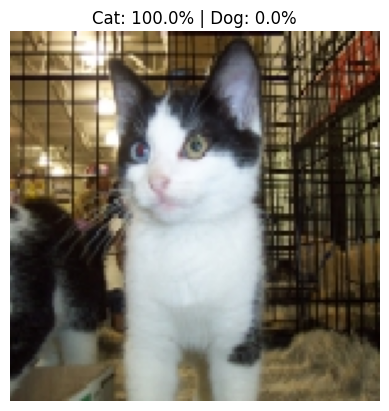

In [24]:
model = load_model_fixed('best_model.pth')
result = predict('/content/drive/MyDrive/Dataset/Cats and Dogs Classification/archive/PetImages/Cat/1000.jpg', model)

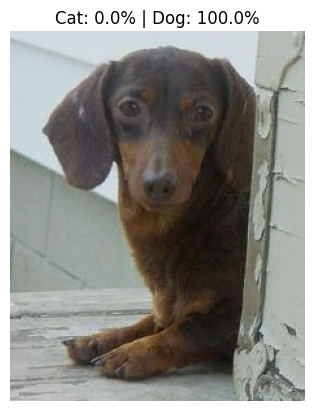

In [25]:
result = predict('/content/drive/MyDrive/Dataset/Cats and Dogs Classification/archive/PetImages/Dog/10288.jpg', model)